In [ ]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
import keras as K
import skimage.measure
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.externals import joblib
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, cohen_kappa_score
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
target_score = "fibrosis_score_pathologist"
# target_score = "ballooning_score_pathologist"
# target_score = "inflammation_score_pathologist"
# target_score = "steatosis_score_cv_based"

score_max = {}
score_max["fibrosis_score_pathologist"] = 4
score_max["ballooning_score_pathologist"] = 2
score_max["steatosis_score_cv_based"] = 3
score_max["inflammation_score_pathologist"] = 3

In [3]:
# Base path
base_path = ".//model_data//Human_liver_score_for_external_OSF_repo//"

# Pathologist ground truth
ground_truth_full_file_name = os.path.join(base_path, "ground_truth.csv")

# Path where ANN models and scaler files for normalization will be saved
model_path = os.path.join(base_path, "model//")

# Path where results from CNN classifications (per tile) are stored
results_path = os.path.join(base_path, "CNN//result")

# Location and filenames of individual CNN classification results
if target_score == "fibrosis_score_pathologist":
    full_results_file_name = "Combined_Train_Liver_fibrosis_model_PT_V0.20_Fibrosis_score.csv"
    model_name = "HS_Liver_fibrosis_model_PT_V0.20"
    target_score_column = "fibrosis_score"
elif target_score == "ballooning_score_pathologist":
    full_results_file_name = "Combined_Train_Liver_ballooning_model_PT_V0.41_Ballooning_score.csv"
    model_name = "Liver_ballooning_model_PT_V0.41"
    target_score_column = "ballooning_score"   
elif target_score == "inflammation_score_pathologist":
    full_results_file_name = "Combined_Train_HS_Liver_inflammation_model_PT_V0.6_Inflammation_score.csv"
    model_name = "Liver_inflammation_model_PT_V0.6"
    target_score_column = "inflammation_score"
elif target_score == "steatosis_score_cv_based":
    full_results_file_name = "Combined_Train_HS_Liver_steatosis_model_IN_V1.2_Steatosis_score.csv"
    model_name = "Liver_steatosis_model_IN_V1.2"
    target_score_column = "steatosis_score"

In [4]:
ground_truth = pd.read_csv(ground_truth_full_file_name, sep = ";", decimal = ",")

In [5]:
# Keep only columns of interest
ground_truth = ground_truth[["id", target_score_column]]

ground_truth = ground_truth.dropna(axis = 0)

In [6]:
ground_truth.tail()

,id,fibrosis_score
462,462,2.0
463,463,0.0
464,464,2.0
465,465,2.0
466,466,0.0


In [7]:
full_results = pd.read_csv(os.path.join(results_path, full_results_file_name), sep = ";", decimal = ".")

In [8]:
full_results.tail()

,0,1,2,3,4,ignore,filenames,x,y,id,...,1_norm,1_norm_bin,2_norm,2_norm_bin,3_norm,3_norm_bin,4_norm,4_norm_bin,weighted_class,uncertainty
140049,0.01,0.01,0.98,0.00,0.00,0.0,466_9_5.png,9,5,466,...,0.01,0.0,0.98,1.0,0.00,0.0,0.00,0.0,1.98,0.02
140050,0.03,0.21,0.74,0.01,0.01,0.0,466_9_6.png,9,6,466,...,0.21,0.0,0.74,1.0,0.01,0.0,0.01,0.0,1.77,0.26
140051,0.00,0.00,0.73,0.21,0.05,0.0,466_9_7.png,9,7,466,...,0.00,0.0,0.73,1.0,0.21,0.0,0.05,0.0,2.30,0.27
140052,0.04,0.13,0.75,0.06,0.01,0.0,466_9_8.png,9,8,466,...,0.13,0.0,0.75,1.0,0.06,0.0,0.01,0.0,1.87,0.25
140053,0.83,0.17,0.00,0.00,0.00,0.0,466_9_9.png,9,9,466,...,0.17,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.17,0.17


In [9]:
def get_scoring_ANN_feature_matrix(classification_result, scaler_file = ""):
    """ Will take a full results dataframe (processed by renormalize_and_process_CNN_results)
        and compute ANN features

        Input:
            classification_result (dataframe)
            Optional: scaler_file: Full path to min max scaler. If empty result will not be scaled.

        Result:
            X, X_scaled (normal and scaled feature matrix)
            slide_id: Dataframe with list of slide_id in exact order as X, X_scaled
    """

    epsilon = 0.0000001

    # Define input features to be used from classification_result
    features = []
    # All columns ending with "_norm"
    for column in classification_result.columns:
        if column.endswith("_norm"):
            features.append(column)

    # Define output features (in X and X_scaled)
    features_X = []
    features_X.append("average_weighted_class")
    for feature in features:
        features_X.append(feature+ "_Shannon_entropy")
        features_X.append(feature + "_mean")
    features_X.append("log_average_weighted_class")

    # Create empty dataframes
    X = pd.DataFrame(columns= features_X)
    X_scaled = pd.DataFrame(columns=features_X)

    # Working list to build dataframe in loop as a list of dicts
    X_list = []
    slide_id_list = []

    # Iterate over classification_result
    for slide_id in classification_result["id"].unique():
        print(slide_id)
        
        slide_id_list.append({"id": slide_id})

        classification_result_subset = classification_result[classification_result["id"] == slide_id]

        x_min = int(np.min(classification_result_subset["x"]))
        x_max = int(np.max(classification_result_subset["x"]))
        y_min = int(np.min(classification_result_subset["y"]))
        y_max = int(np.max(classification_result_subset["y"]))

        features_X_dict = {}
        for feature in features:
            # Create temporary 2d feature image to compute entropy with skimage
            feature_img = np.empty(shape=(int(x_max - x_min + 1), int(y_max - y_min + 1)))
            feature_img[:] = epsilon

            for index_full_results, row_full_results in classification_result_subset.iterrows():
                x = int(row_full_results["x"] - x_min)
                y = int(row_full_results["y"] - y_min)

                feature_img[x, y] = row_full_results[feature]

                if feature_img[x, y] == 0:
                    feature_img[x, y] = epsilon

                if np.isnan(feature_img[x, y]):
                    feature_img[x, y] = epsilon

            # Entropy of p1, p2, ...
            shannon_entropy = skimage.measure.shannon_entropy(feature_img)
            features_X_dict[feature + "_Shannon_entropy"] = shannon_entropy

            # Average feature of (p0, p1, ...
            feature_mean = np.mean(classification_result_subset[feature])
            features_X_dict[feature + "_mean"] = feature_mean

        # Average of weighted class
        average_weighted_class = np.mean(classification_result_subset["weighted_class"])
        features_X_dict["average_weighted_class"] = average_weighted_class

        # Log of average weighted class
        log_average_weighted_class = np.log(average_weighted_class)
        features_X_dict["log_average_weighted_class"] = log_average_weighted_class

        X_list.append(features_X_dict)

    X = pd.DataFrame(X_list)

    # Reorder columns
    X = X[features_X]

    # Load scaler
    if (scaler_file):
        scaler = joblib.load(scaler_file)

        # transform X with previously saved min-max scaler
        X_scaled = scaler.transform(X)
    else:
        X_scaled = []    
    
    slide_id_df = pd.DataFrame(slide_id_list)

    return X, X_scaled, slide_id_df

In [10]:
X, X_scaled, slide_id_df = get_scoring_ANN_feature_matrix(full_results)
# Note: X_scaled is empty, since no scaler_file is available during training

2
3
5
6
8
9
10
11
13
14
15
17
22
20
23
27
29
31
32
33
34
37
38
41
43
44
45
47
48
50
52
55
58
60
62
135
63
64
65
66
67
68
69
70
71
73
74
75
76
77
79
80
82
83
84
85
86
87
90
92
93
94
95
96
97
98
99
102
104
105
106
110
112
113
115
116
117
118
119
120
123
124
125
126
127
128
129
130
131
132
133
134
159
160
161
162
163
167
168
169
170
171
172
173
174
151
152
153
155
156
176
177
181
183
184
187
188
194
195
198
200
204
205
209
210
215
216
212
221
223
225
228
229
230
231
232
236
237
238
240
241
243
244
246
247
249
252
253
255
256
258
259
260
262
263
264
266
267
268
269
270
271
272
273
274
275
280
282
283
285
286
288
287
291
292
293
295
297
301
302
303
304
305
307
308
312
314
316
318
321
322
323
325
326
334
352
354
357
358
360
368
369
374
375
376
377
378
379
381
382
384
385
387
389
390
392
393
394
397
396
398
399
400
401
402
405
406
407
408
410
411
416
417
418
420
421
422
423
424
425
427
429
430
431
432
433
434
435
436
437
438
440
441
442
443
444
445
446
448
449
450
451
452
453
454
455
456
457


In [11]:
X["id"] = slide_id_df["id"]

In [12]:
X.shape

(275, 13)

In [13]:
# Save unscaled weights, so that features do not need to be created each time
X.to_csv(os.path.join(base_path, "ANN//X", full_results_file_name[:-4] + "_X" + ".csv"), index = False, sep = ";", decimal=",", float_format='%.4f')

In [14]:
# Keep only X values where we have available ground truth for
X = X[X["id"].isin(ground_truth["id"])]

In [15]:
X.shape

(225, 13)

In [16]:
# Construct Y (ground truth) in the same order as X (features)
Y_data = []

for index, row in X.iterrows():
    
    slide_id_str = row["id"]
    score = int(float(ground_truth[ground_truth["id"] == slide_id_str][target_score_column]))
        
    Y_data.append({"id": row["id"], target_score_column : score})
    
Y = pd.DataFrame(Y_data)

In [17]:
X_Y = X.merge(Y, on = ["id"])

# Optional
# X_Y.to_csv(os.path.join(model_path, full_results_file_name[:-4] + "_X_Y" + ".csv"), index = False, sep = ";", decimal=",", float_format='%.4f')

In [18]:
X_Y

,average_weighted_class,0_norm_Shannon_entropy,0_norm_mean,1_norm_Shannon_entropy,1_norm_mean,2_norm_Shannon_entropy,2_norm_mean,3_norm_Shannon_entropy,3_norm_mean,4_norm_Shannon_entropy,4_norm_mean,log_average_weighted_class,id,fibrosis_score
0,1.171035,7.899933,0.286520,8.404122,0.422907,7.411710,0.184978,6.709523,0.042863,6.362523,0.061784,0.157888,2,2
1,0.864512,6.838021,0.485793,6.611893,0.240549,5.904274,0.227134,4.216028,0.013293,3.881828,0.031098,-0.145590,5,0
2,2.064637,7.306966,0.189055,7.891524,0.272066,7.206297,0.125626,7.357105,0.108176,7.731327,0.303692,0.724955,6,3
3,1.278146,7.320232,0.169000,8.375098,0.618171,6.603034,0.063341,6.199967,0.063317,6.349997,0.085146,0.245411,8,3
4,1.625061,8.846545,0.230677,9.026727,0.164896,9.456843,0.410174,8.548836,0.135313,7.689018,0.057717,0.485545,10,1
5,1.044597,7.739146,0.266650,8.332433,0.540220,6.788715,0.105477,6.164989,0.055648,5.665417,0.030660,0.043631,14,2
6,1.501382,5.940131,0.315366,5.966079,0.235854,5.836206,0.235041,5.024997,0.056504,5.278880,0.155691,0.406386,15,3
7,1.268579,8.265106,0.331241,8.507873,0.345432,7.540641,0.143561,6.960323,0.081259,6.926848,0.097230,0.237897,23,2
8,1.312350,7.890483,0.345092,8.072578,0.299263,7.271297,0.156544,6.868453,0.095207,6.571061,0.103018,0.271820,31,3
9,0.958239,9.323522,0.388478,9.501269,0.386080,8.253264,0.132259,7.512133,0.063542,6.801179,0.028239,-0.042658,32,2


In [19]:
# Set final X and Y

# X without slide id
X = X.drop(columns = ["id"], axis = 1)

# Y with target score
Y = X_Y[target_score_column]

In [20]:
def create_ANN(input_dim, max_score_):
    """ Create the scoring ANN

    input:
        input_dim: number of dimensions for inpit
        max_score_: restrict output to 0...max_score

    output:
        model: ANN model (Keras)
    """

    # Activation function with predefined range of score
    global max_score
    max_score = max_score_

    def mapping_to_target_range(x, target_min=0):
        global max_score
        target_max = max_score

        z = K.backend.tanh(x) + 1
        scale = (target_max - target_min) / 2.
        return z * scale + target_min

    # define MLP network
    model = Sequential()
    model.add(Dense(100, input_dim = input_dim, activation="elu"))
    model.add(Dropout(0.8))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(1, activation = mapping_to_target_range))

    # model
    return model

In [21]:
sample_weights_dict = {}

for y_unique in np.unique(Y):            
    sample_weights_dict[y_unique] = len(Y) / np.sum(Y == y_unique)
    
print(sample_weights_dict)

{0: 5.921052631578948, 1: 5.487804878048781, 2: 3.0405405405405403, 3: 4.591836734693878, 4: 9.782608695652174}


In [23]:
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X))

# Save scaler for later use
scaler_filename = os.path.join(model_path, model_name + ".scaler")
joblib.dump(scaler, scaler_filename) 

In [24]:
def fit_scoring_ANN(X_train, Y_train, X_val, Y_val, model_name, n_epochs, score_max):
    # Clean up memory
    K.backend.clear_session()
    
    mlp = create_ANN(X_train.shape[1], score_max)
        
    optimizer = optimizers.Nadam(lr = 0.0003)        
    
    if len(X_val) > 0:
        callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, cooldown=75, verbose=0, min_lr=1e-8),
                     ModelCheckpoint(model_name, monitor='val_loss', verbose=0, save_best_only=True)] 
        
        val_data = (X_val, Y_val)
    else:
        callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.9, patience=2, cooldown=75, verbose=0, min_lr=1e-8)]         
        
        val_data = None
    
    mlp.compile(loss = "mean_squared_error", metrics = ["accuracy", "mean_squared_error"], optimizer = optimizer)
    history = mlp.fit(X_train, Y_train, validation_data= val_data, epochs = n_epochs, verbose = 0, class_weight = sample_weights_dict, callbacks = callbacks)
    
    return mlp, history

In [25]:
def plot_history(history, save_file_name = ""):
    fig, ax1 = plt.subplots()    
    
    if ("val_loss" in history.history):
        ax2 = ax1.twinx()
        l2 = ax2.plot(history.history['val_loss'], color = "blue", alpha = 0.8, label = "Validation")
        ax2.set_ylabel('Val MSE loss')
        
    l1 = ax1.plot(history.history['loss'], color = "red", alpha = 0.8, label = "Training") 
    ax1.set_ylabel('Training MSE loss')
        
    plt.title('%s - ANN' % (target_score))
    plt.xlabel('epoch')
    
    # https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
    fig.legend(loc = [0.55, 0.7])        
    
    if save_file_name:    
        plt.savefig(save_file_name, dpi = 300, bbox_inches='tight')
        
    plt.show()    

In [26]:
def plot_cont_score_vs_path_score(AI_score, ground_truth, target_score, save_plot = True):
    if target_score == "fibrosis_score_pathologist":
        key = "Continuous_AI_fibrosis_score"
        score_str = "Fibrosis_score"
        title_str = "Fibrosis"    
    elif target_score == "ballooning_score_pathologist":
        key = "Continuous_AI_ballooning_score"
        score_str = "Ballooning_score"
        title_str = "Ballooning"
    elif target_score == "inflammation_score_pathologist":
        key = "Continuous_AI_inflammation_score"
        score_str = "Inflammation_score"
        title_str = "Inflammation"
    elif target_score == "steatosis_score_cv_based":
        key = "Continuous_AI_steatosis_score"
        score_str = "Steatosis_score"
        title_str = "Steatosis"    

    col_str = {"Inflammation_score": "#ff1f20", "Ballooning_score" : "#32cd32", "Steatosis_score" : "b", "Fibrosis_score" : "#111111"}

    score_label_str = score_str.replace("_", " ").capitalize()
    score_label_str = score_label_str.replace("pathologist", "")

    if (score_str != "Fibrosis_score"):
        score_label_str = score_label_str.replace("score", "sub-score / sample")
    else:
        score_label_str = score_label_str.replace("score", "score / sample")

    if target_score != "steatosis_score_cv_based":
        score_label_str = score_label_str + "\n(Human expert)"

    matplotlib.rcParams.update({'font.size': 14})
    fig = plt.figure()
    ax = plt.subplot(111) 
    jitter = 0.06

    ax.scatter(AI_score, ground_truth + np.random.normal(0, jitter, ground_truth.shape[0]), c = col_str[score_str], alpha=0.4, s=20)

    plt.ylabel(score_label_str)        
    plt.xlabel(key)   
    plt.title(title_str)

    if save_plot:
        fig_file_name_str = os.path.join(model_path, full_results_file_name[:-4]) + ".png"
        fig.savefig(fig_file_name_str, bbox_inches='tight', dpi=600)
        print("Figure saved")

In [27]:
def save_confusion_matrix(y_true, y_pred, save_file_name, label_list = []):
    cm = confusion_matrix(y_true, y_pred)

    matplotlib.rcParams.update({'font.size': 20})

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    
    if len(label_list):
        tick_marks = np.arange(len(label_list))
        plt.xticks(tick_marks, label_list, rotation=0)
        plt.yticks(tick_marks, label_list)
    else:
        tick_marks = np.arange(len(np.unique(y_true)))
        plt.xticks(tick_marks, sorted(np.unique(y_true)), rotation=0)
        plt.yticks(tick_marks, sorted(np.unique(y_true)))            

    plt.gca().invert_yaxis()
    fmt = 'd'
    thresh = cm_norm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")
    
    plt.ylabel('Pathologist score')
    plt.xlabel('Rounded AI-score')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.tight_layout()

    plt.savefig(save_file_name, dpi=600)

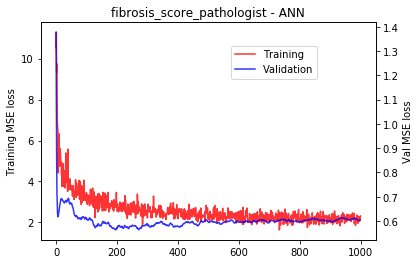

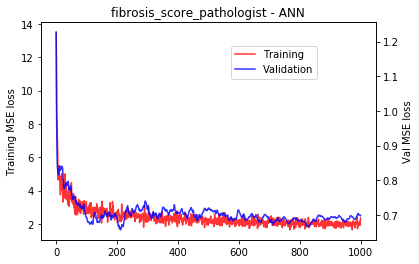

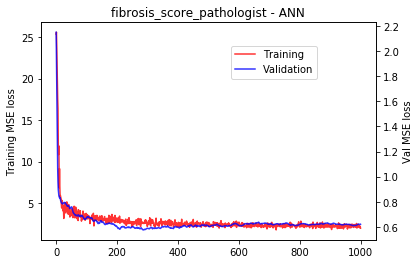

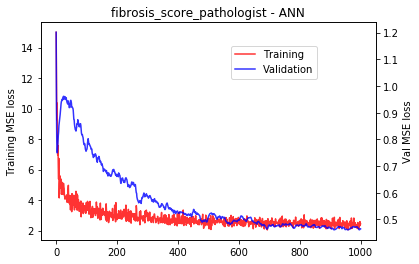

In [28]:
# K-fold cross validation
np.random.seed(10)

kf = KFold(n_splits = 4, shuffle = True)
cross_val_model_name = os.path.join(model_path, "cv_tmp_model.h5")

# Dataframe to hold predictions on val and ground truth
pred_vs_gt = pd.DataFrame(X_Y[["id", target_score_column]])
pred_vs_gt["ANN_score"] = np.NaN

i = 0

for train_index, val_index in kf.split(X_scaled, Y):            
    X_train = X_scaled.iloc[train_index]
    X_val = X_scaled.iloc[val_index]
    
    Y_train = Y.iloc[train_index]
    Y_val = Y.iloc[val_index]    
    
    # Fit ANN    
    mlp, history = fit_scoring_ANN(X_train, Y_train, 
                                   X_val, Y_val,
                                   cross_val_model_name, 
                                   n_epochs = 1000,
                                   score_max = score_max[target_score])
    
    # Plot history
    plot_history(history)

    # Load best model
    # predict held back validation samples
    # add predictions on val to merged summary 
    mlp.load_weights(cross_val_model_name)           
    Y_val_pred = mlp.predict(X_val)
    
    pred_vs_gt.loc[val_index, "ANN_score"] = Y_val_pred
        
    i = i + 1
    
os.remove(cross_val_model_name)

### Make plot of cross-validated data

Figure saved


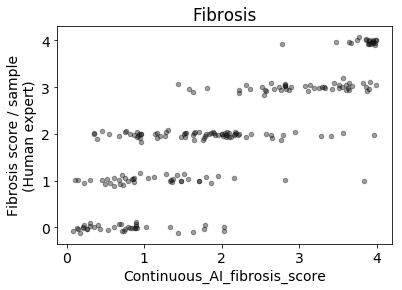

In [30]:
plot_cont_score_vs_path_score(pred_vs_gt["ANN_score"], pred_vs_gt[target_score_column], target_score)

In [ ]:
# Save ANN predictions (4xCV) with ground truth
summary_results_file_name = full_results_file_name[:-4] + "_ANN_summary.csv"

pred_vs_gt.rename(columns = {"ANN_score" : "ANN_" + target_score_column}, inplace = True)
pred_vs_gt.to_csv(os.path.join(base_path, "ANN//result//", summary_results_file_name), sep = ";", decimal=",", float_format='%.3f', index = False)

### Train model on all data

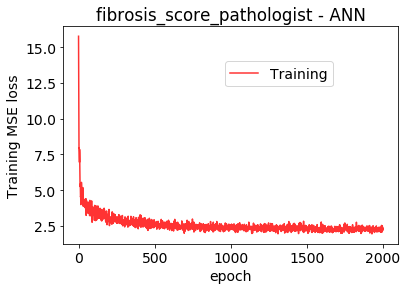

In [31]:
# Fit ANN on all data for application to new data
mlp, history = fit_scoring_ANN(X_scaled, Y, [], [], os.path.join(model_path, model_name + "test_ANN.csv"), n_epochs = 2000, score_max = score_max[target_score])
plot_history(history, save_file_name = os.path.join(model_path, model_name + "_ANN.png"))

In [ ]:
# Save weights
mlp.save(os.path.join(model_path, model_name + "_ANN.h5"))

In [ ]:
# To verify the model predictions, run on all data again
Y_pred = mlp.predict(X_scaled)

In [ ]:
Y_pred = Y_pred.flatten()

In [ ]:
plot_cont_score_vs_path_score(Y_pred, X_Y[target_score_column], target_score, save_plot = False)